In [6]:
import numpy as np
from glob import glob
import os, sys
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from skopt.space import Real
from skopt import BayesSearchCV
from scf_guess_tools import Backend, load, calculate

train_test_seed = 42
np.random.seed(train_test_seed)

source_path = '../../datasets/QM9/xyz_c7h10o2_sorted/'
old_source_path = '../../datasets/QM9/xyz_c7h10o2/'
all_file_paths = glob(os.path.join(source_path, '*.xyz'))
len(all_file_paths)

6095

In [7]:
# take only certain paths (RAM issues)
all_file_paths = np.random.choice(all_file_paths, 1001, replace=False)
len(all_file_paths)

1001

In [30]:
scripts_path = "../../scripts"
if scripts_path not in sys.path:
    sys.path.append(scripts_path)
from to_cache import density_fock_overlap
sys.path.append(os.path.join(".."))
from utils import  flatten_triang, unflatten_triang, plot_fock_comparison, reorder_Matrix_using_xyz_perm, flatten_triang_batch, reconstruct_Fock, density_from_fock
BASIS_PATH = "../../scripts/6-31g_2df_p_custom_nwchem.gbs"
if not os.path.exists(BASIS_PATH):
    raise FileNotFoundError(f"Basis set file not found at {BASIS_PATH}")

In [9]:
def load_cached(file_paths, cache_path, basis, guess="minao", method="dft", functional="b3lypg", backend="pyscf"):
    error_list = []
    error_files = []
    focks = []
    overlaps = []
    used_files = []
    reference_densities = []
    for file in file_paths:
        mol_name = os.path.basename(file).strip()
        # print(mol_name)
        try: 
            ret = density_fock_overlap(filepath = file,
                                filename = mol_name,
                                method = method,
                                basis = None,
                                functional = functional,
                                guess = guess,
                                backend = backend,
                                cache = cache_path)
            # print(f"Using: file={file} - mol_name={mol_name} - basis={None} - guess={guess} - method={method} - functional={functional}")
        except Exception as e: 
            error_list.append(e)
            error_files.append(mol_name)
            print(f"File {mol_name} error - skipping")
            continue
        if any([r == None for r in ret]): 
            print(f"File {mol_name} bad - skipping")
            continue
        #! REORDER MATRICES!!! -> using the old and new filepaths + mol! 
        density_orig = ret[0].numpy
        fock_orig = ret[1].numpy
        overlap_orig = ret[2].numpy
        file_old = os.path.join(old_source_path, mol_name)
        assert os.path.exists(file_old), f"Old file not found at {file_old}"
        mol_old = load(file_old, backend=Backend.PY, basis=BASIS_PATH).native
        fock = reorder_Matrix_using_xyz_perm(fock_orig, file_old, file, mol_old)
        density = reorder_Matrix_using_xyz_perm(density_orig, file_old, file, mol_old)
        overlap = reorder_Matrix_using_xyz_perm(overlap_orig, file_old, file, mol_old)

        focks.append(fock)
        used_files.append(file)
        reference_densities.append(density)
        overlaps.append(overlap)
    print(f"Got data for: {len(focks)} - bad / no ret: {len(file_paths) - len(focks) - len(error_list)} - errors: {len(error_list)}")
    print(error_files[:5])
    return focks, reference_densities, overlaps, used_files


In [10]:
ret = load_cached(all_file_paths, "../../datasets/QM9/out/c7h10o2_b3lypg_6-31G(2df,p)/pyscf", basis="6-31g_2df_p_custom_nwchem.gbs")

File dsgdb9nsd_060790.xyz bad - skipping
Got data for: 1000 - bad / no ret: 1 - errors: 0
[]


# Split Dataset & scaling

In [21]:
from sklearn.linear_model import Ridge
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.linear_model import RidgeCV
from sklearn.multioutput import MultiOutputRegressor
import pickle
import time

In [20]:
fock_tr, fock_te, density_tr, density_te, overlap_orig_tr, overlap_orig_te, used_files_tr, used_files_te = train_test_split(*ret, test_size=0.2, random_state=train_test_seed)

scaler_overlap = StandardScaler()
scaler_overlap.fit(flatten_triang_batch(np.array(overlap_orig_tr)))

overlap_tr = scaler_overlap.transform(flatten_triang_batch(np.array(overlap_orig_tr)))
overlap_te = scaler_overlap.transform(flatten_triang_batch(np.array(overlap_orig_te)))


train = (fock_tr, density_tr, overlap_tr)
test = (fock_te, density_te, overlap_te)
overlap_te.shape, overlap_tr.shape

((200, 40470), (800, 40470))

In [19]:
def summary(X, name):
    print(f"Summary {name}:")
    # print(f"Shape: {X.shape}")
    print(f"Mean: {np.mean(X)}")
    print(f"Std Dev: {np.std(X)}")
    print(f"Min: {np.min(X)}")
    print(f"Max: {np.max(X)}")

summary(overlap_tr, "X_train")
summary(overlap_te, "X_test")

Summary X_train:
Mean: 1.0567282161739815e-19
Std Dev: 0.9582461740964573
Min: -28.266586934625078
Max: 28.266587803105423
Summary X_test:
Mean: 0.0003216026968987298
Std Dev: 0.9830304363603866
Min: -249.22919342696778
Max: 102.34801848297315


# Dimensionality reduction otherwise it takes ages! 

In [26]:
# define train vars
X_train = overlap_tr
y_train = [np.diag(fock) for fock in fock_tr]
X_test = overlap_te
y_test = [np.diag(fock) for fock in fock_te]

In [61]:
model = MultiOutputRegressor(Ridge(alpha=10000))
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
train_rmse = root_mean_squared_error(y_train, model.predict(X_train))
test_rmse = root_mean_squared_error(y_test, y_pred)
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Train RMSE: 0.01382792265786553
Test RMSE: 0.04286991932505193


Fock Comparison. 

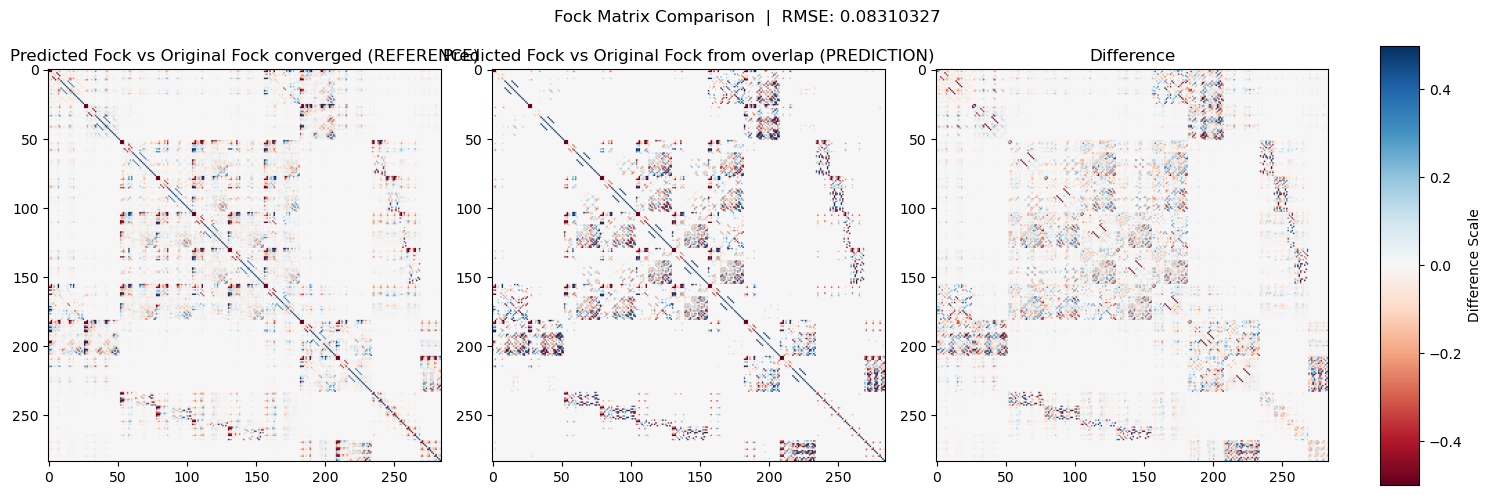

In [ ]:
example_index = np.random.randint(0, len(y_test))
fock_diag = model.predict(X_test[example_index].reshape(1, -1))[0]

predictedFockGWH = reconstruct_Fock(fock_diag, overlap_orig_te[example_index])

plot_fock_comparison(fock_te[example_index], predictedFockGWH, predictedFockGWH.shape[0], "Predicted Fock vs Original Fock", vmax=0.5)


Density Comparison

Number of electrons: 34


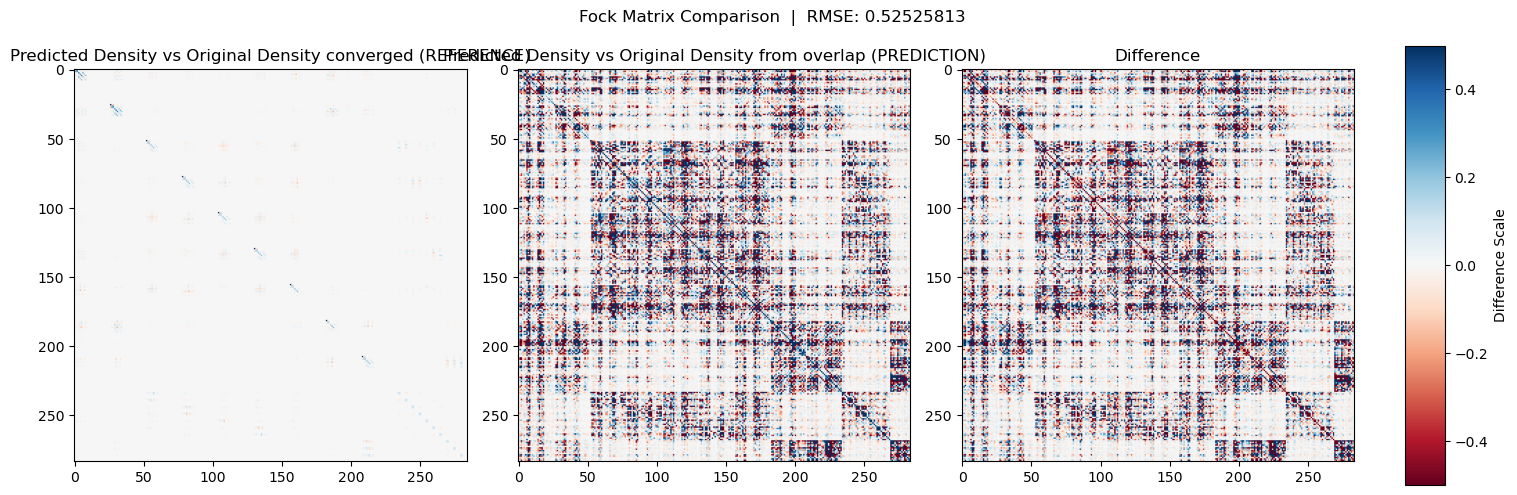

In [74]:
nelec = load(used_files_te[example_index], backend=Backend.PY, basis=BASIS_PATH).native.nelec[0]
print(f"Number of electrons: {nelec}")
predictedDensityGWH = density_from_fock(predictedFockGWH, overlap_orig_te[example_index], nocc=2*nelec)
plot_fock_comparison(density_te[example_index], predictedDensityGWH, predictedDensityGWH.shape[0], "Predicted Density vs Original Density", vmax=0.5)